In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Carregar os dados
df = pd.read_csv('manga.csv')

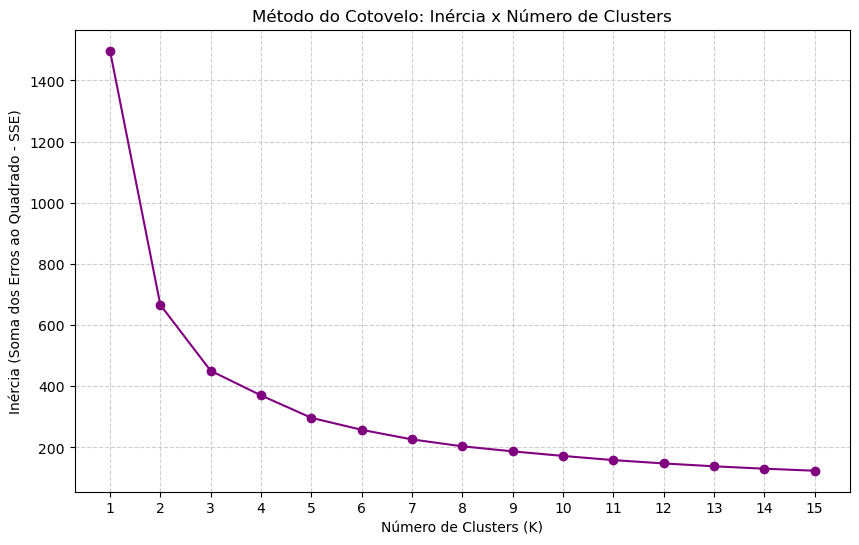

In [59]:
X = df[['score', 'log_scored_by', 'log_members', 'log_favorites']]

inercias = []
k_range = range(1, 16)  # Testando de 1 a 15 clusters (igual à imagem)

# 2. Loop para calcular o K-Means para cada número de clusters
for k in k_range:
    # Cria o modelo com k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # Treina o modelo
    kmeans.fit(X)
    
    # Armazena a inércia (Soma dos Erros ao Quadrado - SSE)
    inercias.append(kmeans.inertia_)

# 3. Plotar o gráfico
plt.figure(figsize=(10, 6)) # Tamanho da figura
plt.plot(k_range, inercias, marker='o', color='purple') # Linha roxa com bolinhas

# Configurações de texto (títulos e eixos iguais aos da imagem)
plt.title('Método do Cotovelo: Inércia x Número de Clusters')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (Soma dos Erros ao Quadrado - SSE)')

# Grade de fundo e ticks do eixo X
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(k_range)

plt.show()


🔹 CLUSTER 0: 2268 mangás
   - Perfil: Score Médio 7.40 | Popularidade Média: 0
   - Categoria Dominante: Romance (93.4%)
   - Rótulo Sugerido: MENOR ALCANCE

🔹 CLUSTER 1: 3217 mangás
   - Perfil: Score Médio 7.53 | Popularidade Média: 0
   - Categoria Dominante: Content_Others (34.2%)
   - Rótulo Sugerido: ALTA QUALIDADE

🔹 CLUSTER 2: 1185 mangás
   - Perfil: Score Médio 7.54 | Popularidade Média: 0
   - Categoria Dominante: Shounen (100.0%)
   - Rótulo Sugerido: ALTA QUALIDADE


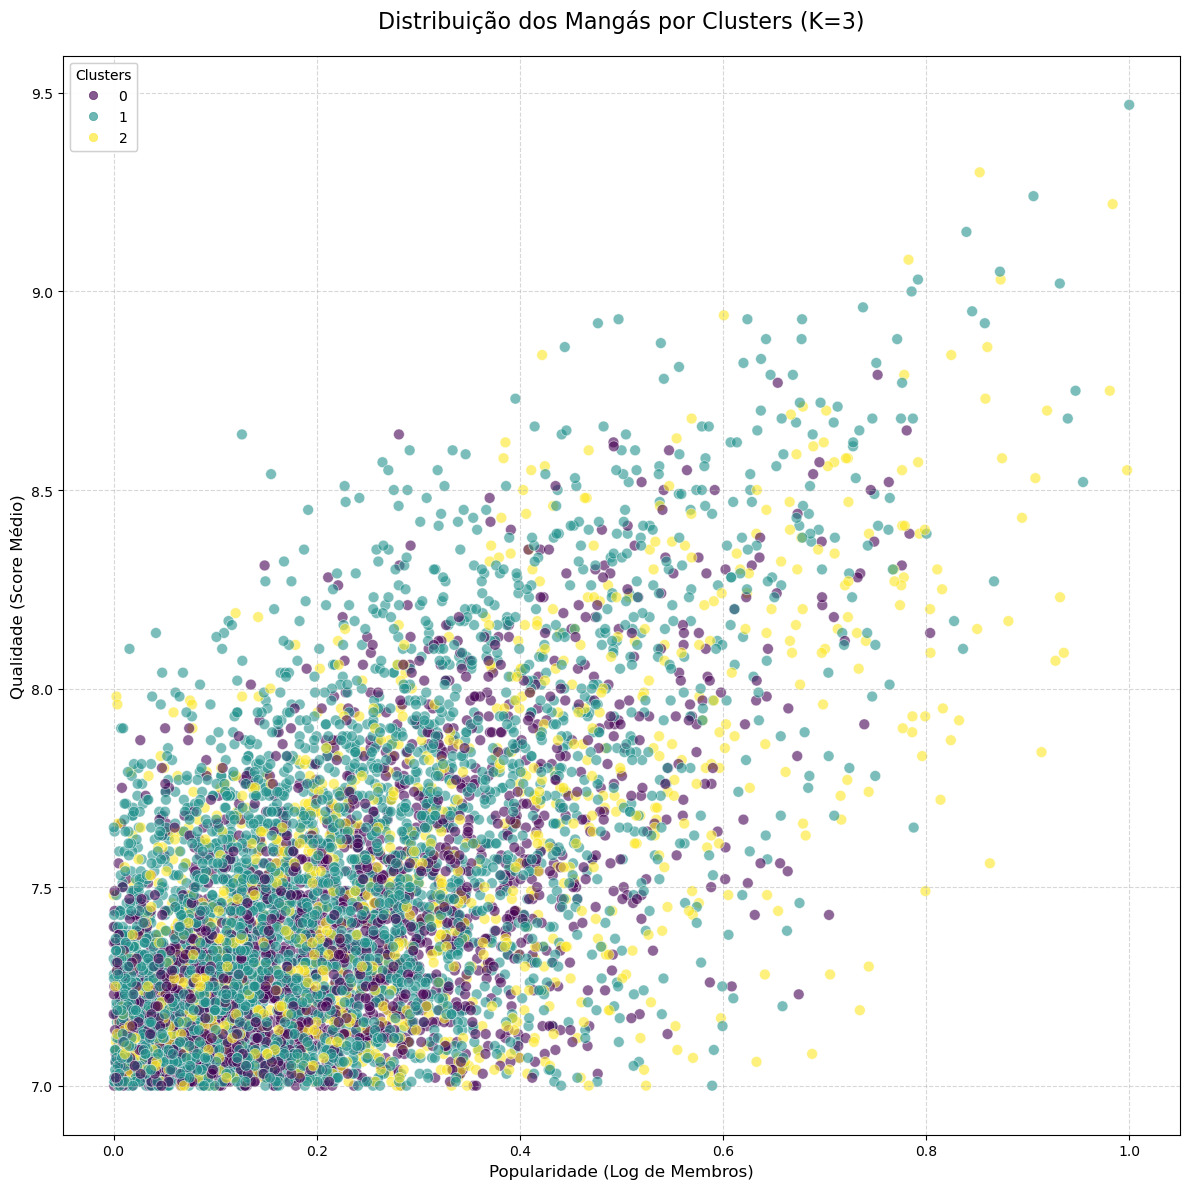

In [62]:
# --- 1. CARREGAMENTO E PREPARAÇÃO DOS DADOS ---
cols_conteudo = [col for col in df.columns if col.startswith(('genres_', 'themes_', 'demographics_')) or col == 'Content_Others']


# X final: Conteúdo (Top 9 + Others) + Métricas Escaladas
X = pd.concat([
    df[cols_conteudo].reset_index(drop=True),
    df[['score', 'log_scored_by', 'log_members', 'log_favorites']]
], axis=1)


# --- 4. APLICAR K-MEANS (K=3) ---
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X)
df['Cluster'] = clusters

metricas_reais = ['score', 'log_members', 'log_favorites']

for i in range(k):
    grupo = df[df['Cluster'] == i]
    n = len(grupo)
    
    # Médias
    media_score = grupo['score'].mean()
    media_members = grupo['log_members'].mean()
    
    # Categoria dominante (excluindo Others para pegar o gênero real mais forte)
    top_cat = grupo[cols_conteudo].mean().idxmax().replace('genres_', '').replace('demographics_', '')
    freq_top = grupo[top_9_cols].mean().max() * 100
    
    print(f"\n🔹 CLUSTER {i}: {n} mangás")
    print(f"   - Perfil: Score Médio {media_score:.2f} | Popularidade Média: {int(media_members):,}")
    print(f"   - Categoria Dominante: {top_cat} ({freq_top:.1f}%)")
    
    # Tentativa de rótulo automático
    if media_members > df['log_members'].mean() * 1.5:
        label = "POPULARES"
    elif media_score > df['score'].mean():
        label = "ALTA QUALIDADE"
    else:
        label = "MENOR ALCANCE"
    print(f"   - Rótulo Sugerido: {label}")


# --- 6. PLOTAR GRÁFICO COM MATPLOTLIB ---
plt.figure(figsize=(12, 12))

# Definir cores e marcadores para os clusters
cores = ['#e74c3c', '#3498db', '#2ecc71'] # Vermelho, Azul, Verde (ajuste se preferir)
labels_cluster = [f'Cluster {i}' for i in range(k)]

scatter = plt.scatter(
    x=df['log_members'], 
    y=df['score'], 
    c=df['Cluster'], 
    cmap='viridis', # Ou use a lista 'cores' com c=[cores[i] for i in df['Cluster']]
    s=60, 
    alpha=0.6, 
    edgecolors='w', 
    linewidth=0.5
)

# Enfeites do Gráfico
plt.title('Distribuição dos Mangás por Clusters (K=3)', fontsize=16, pad=20)
plt.xlabel('Popularidade (Log de Membros)', fontsize=12)
plt.ylabel('Qualidade (Score Médio)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Criar legenda personalizada
legend = plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper left")
plt.gca().add_artist(legend)

# Anotações explicativas (opcional, baseada na média dos clusters calculada acima)
# Isso ajuda a visualizar onde está o centro de cada grupo no gráfico
centros_x = df.groupby('Cluster')['log_members'].mean()
centros_y = df.groupby('Cluster')['score'].mean()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def gerar_regras_associacao(df_input, min_lift=1.2, min_conf=0.3):
    """
    Gera regras de associação (A -> B) usando álgebra matricial.
    Não requer bibliotecas externas como mlxtend.
    """
    print("--- Iniciando Mineração de Regras de Associação ---")
    
    cols = [c for c in df_input.columns if c.startswith(('genres_', 'themes_', 'demographics_'))]

    data = df_input[cols].fillna(0)
    data = (data > 0).astype(int)
    suporte_minimo_item = 0.01 
    suporte_itens = data.mean()
    cols_ativas = suporte_itens[suporte_itens >= suporte_minimo_item].index
    
    data = data[cols_ativas]
    suporte_itens = suporte_itens[cols_ativas]
    n_itens = len(cols_ativas)

    matriz_coocorrencia = data.T.dot(data) / len(data)

    # Suporte(AB)
    support_matrix = matriz_coocorrencia.values
    # Suporte(A) e Suporte(B)
    suporte_vals = suporte_itens.values
    
    # Confiança(A->B) = Suporte(AB) / Suporte(A)
    # Broadcasting: Divide cada linha pelo suporte do antecedente (item da linha)
    confidence_matrix = support_matrix / suporte_vals[:, None]
    
    # Lift(A->B) = Confiança(A->B) / Suporte(B)
    # Broadcasting: Divide cada coluna pelo suporte do consequente (item da coluna)
    lift_matrix = confidence_matrix / suporte_vals[None, :]
    
    # 4. Extrair e Filtrar Regras
    regras = []
    
    # Encontrar índices onde Lift > min_lift
    rows, cols_idxs = np.where(lift_matrix >= min_lift)
    
    for r, c in zip(rows, cols_idxs):
        if r == c: continue # Ignora A -> A
        
        conf = confidence_matrix[r, c]
        if conf < min_conf: continue # Filtro de Confiança
        
        # Limpeza dos nomes para ficar legível
        ant_nome = cols_ativas[r].replace('genres_', '').replace('themes_', '').replace('demographics_', '')
        cons_nome = cols_ativas[c].replace('genres_', '').replace('themes_', '').replace('demographics_', '')
        
        regras.append({
            'Antecedente': ant_nome,
            'Consequente': cons_nome,
            'Suporte': support_matrix[r, c],
            'Confiança': conf,
            'Lift': lift_matrix[r, c]
        })
    
    df_regras = pd.DataFrame(regras)
    
    if not df_regras.empty:
        df_regras = df_regras.sort_values('Lift', ascending=False)
        print(f"✅ Sucesso! {len(df_regras)} regras encontradas.")
    else:
        print("⚠️ Nenhuma regra encontrada com os filtros atuais.")
        
    return df_regras



df = pd.read_csv('manga.csv')

# Gerar as regras
# min_lift=1.2: Queremos combinações que são 20% mais prováveis do que o acaso
# min_conf=0.4: Pelo menos 40% das vezes que A acontece, B também deve acontecer
regras_df = gerar_regras_associacao(df, min_lift=1.2, min_conf=0.4)

# Exibir as Top 15 Regras
print("\n🔹 TOP 15 REGRAS DE ASSOCIAÇÃO (Ordenadas por Lift):")
print(regras_df.head(15).to_string(index=False))

# Salvar
regras_df.to_csv('regras_associacao_manga.csv', index=False)

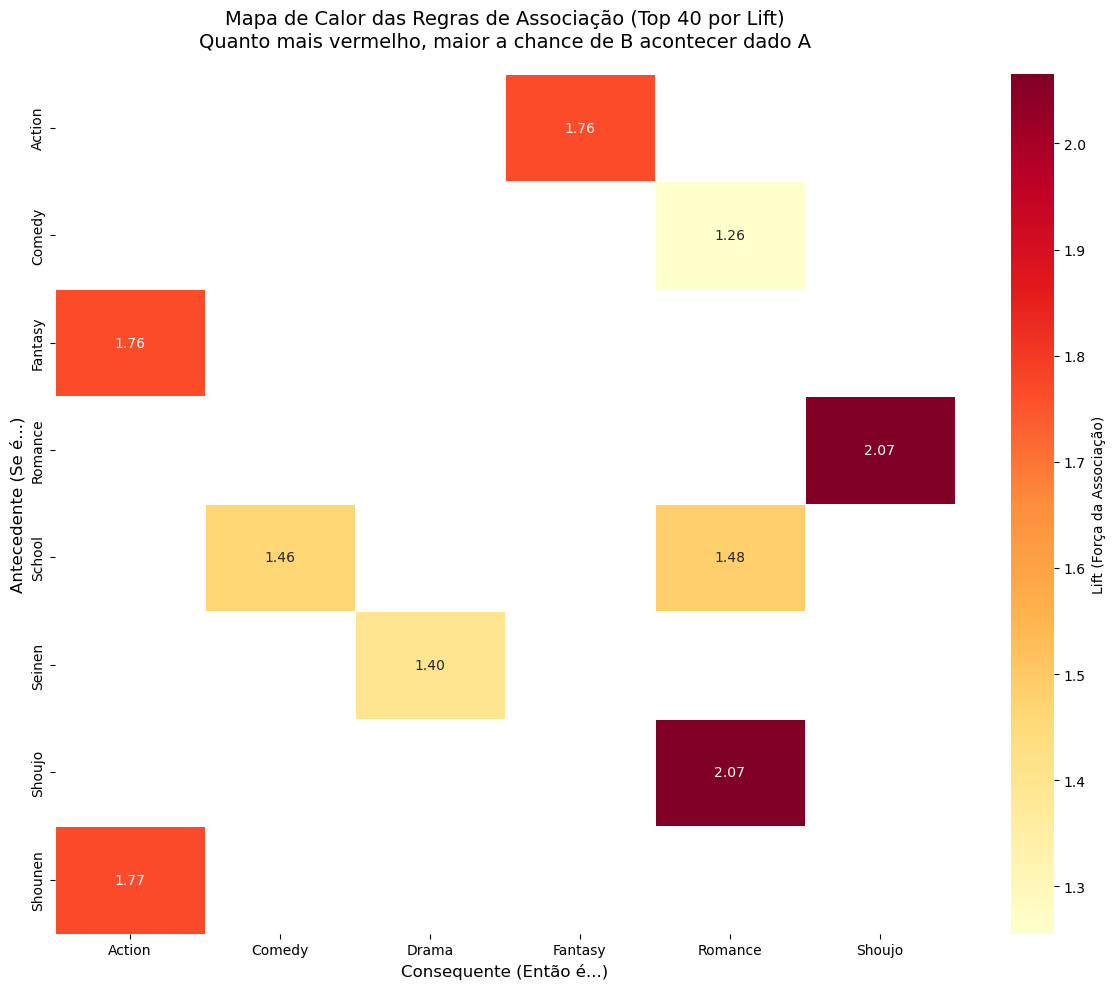

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. PREPARAÇÃO (Garantir que regras_df existe) ---
# Caso o código anterior não tenha sido rodado na mesma sessão, 
# verificamos se o DataFrame 'regras_df' existe. Se não, recriamos rapidamente.
if 'regras_df' not in locals():
    # Tenta carregar o arquivo CSV gerado anteriormente
    try:
        regras_df = pd.read_csv('regras_associacao_manga.csv')
    except:
        print("⚠️ DataFrame 'regras_df' não encontrado. Por favor, execute a mineração de regras primeiro.")
        regras_df = pd.DataFrame()

# --- 2. FILTRAGEM E PIVOTAGEM ---

if not regras_df.empty:
    # Para o gráfico não ficar gigante e ilegível, vamos pegar as Top 20 ou 30 regras
    # ou filtrar por um Lift mais alto para focar no que importa.
    regras_plot = regras_df.head(40).copy() # Pegando as 40 mais fortes para visualização
    
    # Criar a Matriz (Pivot Table)
    # Índice (Linhas) = Antecedente (SE...)
    # Colunas = Consequente (ENTÃO...)
    # Valores = Lift (Força da associação)
    matrix_regras = regras_plot.pivot(index='Antecedente', columns='Consequente', values='Lift')
    
    # --- 3. PLOTAGEM DO HEATMAP ---
    plt.figure(figsize=(12, 10))
    
    # Desenhar o Heatmap
    sns.heatmap(
        matrix_regras, 
        annot=True,       # Escrever o valor do Lift dentro do quadrado
        fmt=".2f",        # Formatação numérica (2 casas decimais)
        cmap="YlOrRd",    # Mapa de cores (Amarelo -> Laranja -> Vermelho)
        linewidths=.5,    # Linhas brancas entre os quadrados
        cbar_kws={'label': 'Lift (Força da Associação)'}
    )
    
    plt.title('Mapa de Calor das Regras de Associação (Top 40 por Lift)\nQuanto mais vermelho, maior a chance de B acontecer dado A', fontsize=14, pad=20)
    plt.xlabel('Consequente (Então é...)', fontsize=12)
    plt.ylabel('Antecedente (Se é...)', fontsize=12)
    
    # Ajustar layout para não cortar labels
    plt.tight_layout()
    plt.show()

else:
    print("❌ Não há regras para plotar. Verifique se a etapa de geração de regras encontrou resultados.")

In [ ]:
print("--- ANÁLISE DETALHADA DOS 3 GRUPOS DE MANGÁS ---")
print("Cálculo das médias por cluster...")


cluster_summary = df.groupby('Cluster').agg({
    'score': 'mean',
    'log_members': 'mean',
    'log_scored_by': 'mean',
    'manga_id': 'count' 
}).rename(columns={'manga_id': 'Total_Mangas'})

cols_conteudo_final = [col for col in df.columns if col.startswith(('genres_', 'themes_', 'demographics_', 'Content_Others'))]

cluster_content_mean = df.groupby('Cluster')[cols_conteudo_final].mean()



print("\n### 1. MÉTRICAS CHAVE POR CLUSTER ###")
# Formatação para melhor leitura
cluster_summary['log_members'] = cluster_summary['log_members'].apply(lambda x: f'{int(x):,}')
cluster_summary['log_scored_by'] = cluster_summary['log_scored_by'].apply(lambda x: f'{int(x):,}')
cluster_summary['score'] = cluster_summary['score'].round(2)

print(cluster_summary)

# --- 2. Perfilamento de Conteúdo ---

print("\n### 2. CARACTERÍSTICAS DOMINANTES POR CLUSTER ###")

for cluster_id in range(3):
    print(f"\n--- CLUSTER {cluster_id} ---")
    
    # 1. Obter o perfil de conteúdo do cluster
    perfil_cluster = cluster_content_mean.loc[cluster_id].sort_values(ascending=False)
    
    # 2. Selecionar as TOP 5 categorias com maior frequência (> 5% de ocorrência)
    top_5_content = perfil_cluster[perfil_cluster > 0.05].head(5)
    
    # 3. Formatar os nomes das colunas e a frequência
    top_5_nomes = [
        col.replace('genres_', '').replace('themes_', '').replace('demographics_', '').replace('Content_Others', 'Outras/Nicho')
        for col in top_5_content.index
    ]
    top_5_freqs = [f'{freq*100:.1f}%' for freq in top_5_content.values]
    
    # 4. Obter as métricas de popularidade/qualidade do cluster
    metrics = cluster_summary.loc[cluster_id]
    
    print(f"   [Performance] Score Médio: {metrics['score']} | Membros Médios: {metrics['log_members']}")
    print(f"   [Conteúdo] Mais Frequente: {top_5_nomes[0]} ({top_5_freqs[0]})")
    print(f"   [Outros Focos]: {', '.join([f'{nome} ({freq})' for nome, freq in zip(top_5_nomes[1:], top_5_freqs[1:])])}")
    
    # Tentativa de Nomear o Cluster (Análise Heurística)
    if metrics['log_members'].replace(',', '').isdigit() and int(metrics['log_members'].replace(',', '')) > df['log_members'].mean() * 3 and metrics['score'] > 7.5:
        print("   💡 INTERPRETAÇÃO: **BLOCKBUSTER POPULAR** (Alto Alcance e Qualidade)")
    elif 'Outras/Nicho' in top_5_nomes[0] and metrics['score'] > 7.0:
        print("   💡 INTERPRETAÇÃO: **NICHO DIVERSIFICADO/CULT** (Menor público, Score razoável)")
    else:
        print("   💡 INTERPRETAÇÃO: **GRUPO BASE/MÉDIO** (Métricas de Engajamento e Qualidade medianas)")

--- ANÁLISE DETALHADA DOS 3 GRUPOS DE MANGÁS ---
Cálculo das médias por cluster...

### 1. MÉTRICAS CHAVE POR CLUSTER ###
         score log_members log_scored_by  Total_Mangas
Cluster                                               
0         7.36           0             0          1883
1         7.58           0             0          2761
2         7.46           0             0          2026
--------------------------------------------------

### 2. CARACTERÍSTICAS DOMINANTES POR CLUSTER ###

--- CLUSTER 0 ---
   [Performance] Score Médio: 7.36 | Membros Médios: 0
   [Conteúdo] Mais Frequente: Romance (94.6%)
   [Outros Focos]: Shoujo (61.8%), School (44.5%), Comedy (41.7%), Outras/Nicho (37.3%)
   💡 INTERPRETAÇÃO: **GRUPO BASE/MÉDIO** (Métricas de Engajamento e Qualidade medianas)

--- CLUSTER 1 ---
   [Performance] Score Médio: 7.58 | Membros Médios: 0
   [Conteúdo] Mais Frequente: Outras/Nicho (259.3%)
   [Outros Focos]: Drama (32.9%), Action (31.6%), Comedy (27.5%), Fantasy (27.3